***Савенкова Марина, гр. 932226***




#Задание

**Регрессор** (вариант чётный)

Оценка уровня потребления ресурсов домохозяйством. Набор данных DS_2019_public.csv. Описание атрибутов – файл recs2009_public_codebook.xlsx. Предсказываемый признак – один из атрибутов (использовать только один из): TOTALBTU, TOTALBTUSPH, TOTALBTUCOL, TOTALBTUWTH, TOTALBTURFG, TOTALBTUOTH (Примечание BTU – Британская тепловая единица BTU ≈ 252 калории).

1.	Выполнить загрузку и предварительную обработку данных из наборов.
2.	Разделить каждую выборку на обучающую, тестовую и валидационную.
3.	Произвести обучение набора нейросетевых архитектур, отличающихся разным набором параметров: число слоёв, количество нейронов в слоях, функции активации в слоях, процедур оптимизации: то есть подобрать архитектуры нейронных сетей, которые с одной стороны позволяют получить модели с лучшими метриками качества работы, с другой стороны не являются избыточными и не переобученными.
4.	Вычислить следующие метрики работы:
Для регрессора: MSE, MAE, R2 для всех полученных моделей.


#Импорт библиотек

In [129]:
import numpy as np
import pandas as pd

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

In [131]:
import missingno as msno

In [132]:
import sklearn as skn

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import auc, roc_curve
from sklearn.utils.class_weight import compute_class_weight

In [133]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

In [134]:
from sklearn.preprocessing import LabelEncoder

In [135]:
from sklearn.metrics import classification_report

In [136]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import metrics

In [137]:
from google.colab import files
from google.colab import drive

In [138]:
# подключение диска

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
path = "/content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/"

#Функции

In [140]:
# функция для визуализации процесса обучения

def mae_and_loss_visualization(history, colors):

  clrs = [
      colors[1],
      colors[len(colors) - 1]
    ]

  train_acc = history.history['mae']
  val_acc = history.history['val_mae']
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(train_loss) + 1)

  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_acc, label='Training MAE', color = clrs[0])
  plt.plot(epochs, val_acc, label='Validation MAE', color = clrs[1])
  plt.title('Training and Validation MAE')
  plt.xlabel('Epochs')
  plt.ylabel('MAE')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_loss, label='Training Loss', color = clrs[0])
  plt.plot(epochs, val_loss, label='Validation Loss', color = clrs[1])
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [141]:
# вывод метрик MSE, MAE, R2

def print_metrics(model, X_test, y_test):

  predictions = model.predict(X_test)
  mse = mean_squared_error(y_test, predictions)
  mae = mean_absolute_error(y_test, predictions)
  r2 = r2_score(y_test, predictions)

  print('Mean squared error from neural network: ', mse)
  print('Mean absolute error from neural network: ', mae)
  print('R2 score from neural network: ', r2)

In [142]:
# функция для визуализации тестовых и предсказанных значений

def prediction_visialization(model, X_test, y_test, colors):

  xx = y_test.index
  yy = y_test.values

  predictions = model.predict(X_test)

  fig = plt.figure()
  ax1 = fig.add_subplot(111)

  ax1.scatter(xx, yy, s = 15, c = colors[0], marker="*", label='test')
  ax1.scatter(xx, predictions, s = 15, c = colors[round(len(colors) / 2)], marker="+", label='predicted')
  plt.legend(loc='upper left')
  plt.show()

#Описание набора данных

В данной работе был использован набор данных DS_2019_public.csv, содержащий информацию о потреблении ресурсов домохозяйством. Описание атбритутов содержится в excel файле. Всего датасет содержит 121 признак.

В качестве целевой переменной была выбрана TOTALBTU - общее потребление (в тысячах BTU).

Загрузим описание признаков в датафрейм и выведем первые 5.

In [143]:
excel_data = pd.read_excel(path + 'task3_descr.xlsx')

excel_df = pd.DataFrame(excel_data, columns=[
    'Variable Name',
    'Variable Description'
    ]
  )
excel_df.head()

,Variable Name,Variable Description
0,DOEID,Unique identifier for each respondent
1,REGIONC,Census Region
2,DIVISION,Census Division
3,REPORTABLE_DOMAIN,Reportable states and groups of states
4,TYPEHUQ,Type of housing unit


#Загрузка набора данных

Загрузим набор данных. Для этого сначала вычислим кодировку файла.

In [144]:
import chardet

with open(path + 'DS_2019_public.csv', 'rb') as f:
    result = chardet.detect(f.read())

Передаем вычисленную кодировку в функцию reas_csv. Теперь преобразование проходит корректно.

In [145]:
df = pd.read_csv(path + 'DS_2019_public.csv', encoding=result['encoding'], engine='python')

df

,Climate_Region_Pub,DIVISION,REPORTABLE_DOMAIN,DOLELCOL,TOTALDOLCOL,KWHCOL,BTUELCOL,TOTALBTUCOL,TOTALDOLSPH,TOTALBTUSPH,...,LGT1EE,TOTALBTUWTH,ROOFTYPE,DOLELRFG,TOTALDOLRFG,HEATROOM,WDWATER,UGWARM,DRYRFUEL,KWHRFG
0,5,10,26,16.793,17,181.998,620.979,621,368,38606,...,-2,30110,2,120.893,121,4,0,1,1,1310.220
1,1,1,1,48.901,49,184.459,629.389,629,582,40248,...,2,7933,-2,242.746,243,2,0,1,-2,915.664
2,1,3,7,101.048,101,1063.022,3627.013,3627,425,40196,...,-2,6440,5,158.797,159,7,0,1,5,1670.534
3,1,1,1,0,0,0.000,0.000,0,616,36136,...,2,13884,5,85.138,85,5,0,1,5,346.468
4,1,4,10,45.132,45,274.530,936.677,937,685,74100,...,3,14204,6,151.319,151,6,0,1,5,920.454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10870,4,5,13,345.8,346,2695.625,9197.516,9198,820,26863,...,8,7179,5,264.409,264,7,0,0,5,2061.159
10871,1,3,9,13.005,13,97.497,332.665,333,521,49610,...,4,6471,6,75.569,76,5,0,1,5,566.544
10872,1,4,10,97.67,98,847.734,2892.504,2893,591,70626,...,-2,24391,6,250.313,250,8,0,1,1,2172.621
10873,1,8,23,12.834,13,135.687,462.975,463,432,49821,...,0,12416,6,175.135,175,5,0,1,1,1851.648


Выведем информацию о датасете.

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10875 entries, 0 to 10874
Columns: 121 entries, Climate_Region_Pub to KWHRFG
dtypes: float64(34), int64(79), object(8)
memory usage: 10.0+ MB


Как видим, у нас есть данные типа 'object', которые необходимо будет закодировать.

Выведем имена столбцов.

In [147]:
colnames = list(df.columns)
colnames

['Climate_Region_Pub',
 'DIVISION',
 'REPORTABLE_DOMAIN',
 'DOLELCOL',
 'TOTALDOLCOL',
 'KWHCOL',
 'BTUELCOL',
 'TOTALBTUCOL',
 'TOTALDOLSPH',
 'TOTALBTUSPH',
 'CELLAR',
 'NWEIGHT',
 'TOTHSQFT',
 'HEATHOME',
 'NUMPC',
 'DOLLAREL',
 'DOLELOTH',
 'CUFEETNGSPH',
 'BTUNGSPH',
 'DOLNGSPH',
 'TEMPHOME',
 'TOTCSQFT',
 'BTUFOSPH',
 'AIRCOND',
 'ELCOOL',
 'GALLONFOSPH',
 'WALLTYPE',
 'TOTALDOLOTH',
 'BTUFO',
 'GALLONFO',
 'DOLFOSPH',
 'DOLLARFO',
 'KWHSPH',
 'BTUELSPH',
 'FOWARM',
 'USEFO',
 'TOTUSQFT',
 'TOTALDOL',
 'NUMTHERM',
 'DOLELSPH',
 'CONCRETE',
 'CUFEETNG',
 'BTUNG',
 'GALLONFOOTH',
 'BTUFOOTH',
 'BEDROOMS',
 'FOWATER',
 'GALLONFOWTH',
 'BTUFOWTH',
 'DOLFOWTH',
 'GALLONKEROTH',
 'BTUKEROTH',
 'DOLKEROTH',
 'TOTUCSQFT',
 'TOTSQFT',
 'TOTSQFT_EN',
 'DOLNGWTH',
 'DOLFOOTH',
 'ELOTHER',
 'DOLLARNG',
 'FUELHEAT',
 'NOTMOIST',
 'GALLONKER',
 'BTUKER',
 'NUMCFAN',
 'FOILAUX',
 'TOTALBTU',
 'COOLTYPE',
 'DOOR1SUM',
 'DOLLARKER',
 'DOLLPOTH',
 'DOLELWTH',
 'KWHWTH',
 'BTUELWTH',
 'TOTROOMS',
 

#Анализ и предварительная обработка данных

In [148]:
# настройка отображения графиков

palette = 'tab20b'

colors = sns.color_palette(palette).as_hex()[:]

##Проверка на пропуски

Визуализируем пропущенные значения с помощью msno.

<Axes: >

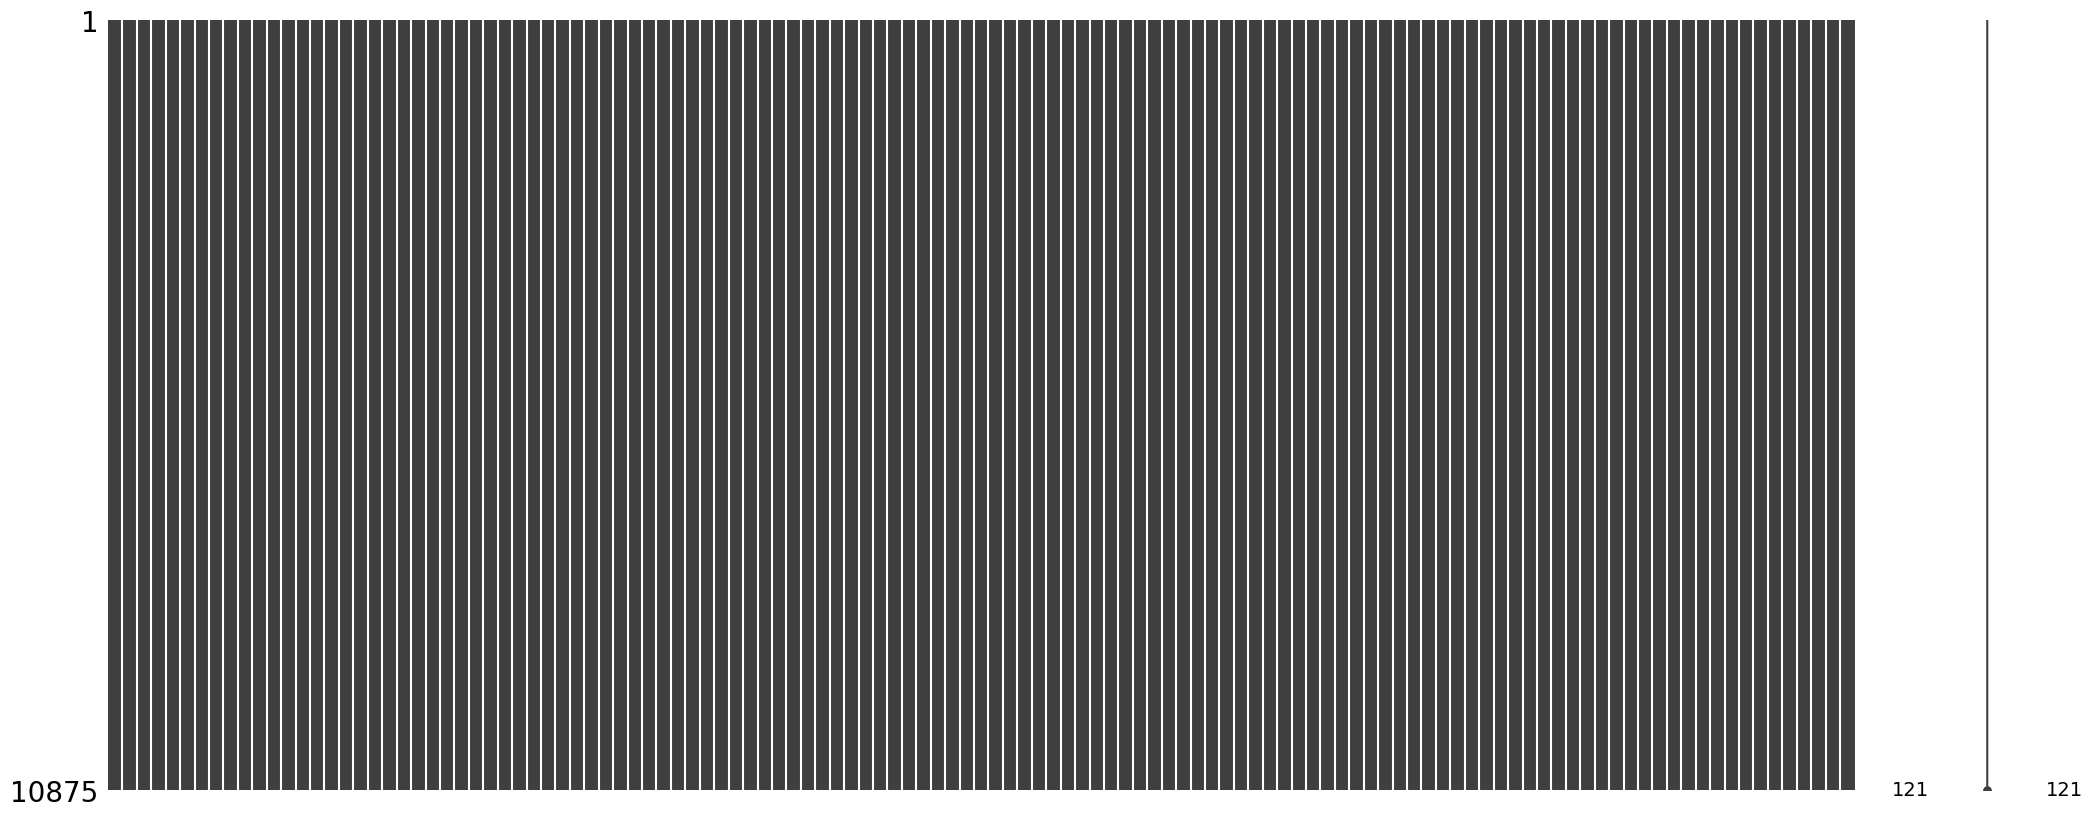

In [149]:
msno.matrix(df)

В датасете отсутствуют пропущенные значения.

## Кодирование категориальных переменных

Скопируем датасет в новый фрейм df_enc и закодируем категориальные признаки.

In [150]:
df_enc = df.copy()

In [151]:
# Кодирование категориальных факторов

for i in df_enc:
    if df_enc[i].dtypes == 'object':
       df_enc[i] = LabelEncoder().fit_transform(df_enc[i])
df_enc

,Climate_Region_Pub,DIVISION,REPORTABLE_DOMAIN,DOLELCOL,TOTALDOLCOL,KWHCOL,BTUELCOL,TOTALBTUCOL,TOTALDOLSPH,TOTALBTUSPH,...,LGT1EE,TOTALBTUWTH,ROOFTYPE,DOLELRFG,TOTALDOLRFG,HEATROOM,WDWATER,UGWARM,DRYRFUEL,KWHRFG
0,5,10,26,1769,17,181.998,620.979,621,368,38606,...,-2,30110,2,1373,121,4,0,1,1,1310.220
1,1,1,1,5993,49,184.459,629.389,629,582,40248,...,2,7933,-2,5545,243,2,0,1,-2,915.664
2,1,3,7,105,101,1063.022,3627.013,3627,425,40196,...,-2,6440,5,3257,159,7,0,1,5,1670.534
3,1,1,1,0,0,0.000,0.000,0,616,36136,...,2,13884,5,9609,85,5,0,1,5,346.468
4,1,4,10,5698,45,274.530,936.677,937,685,74100,...,3,14204,6,2933,151,6,0,1,5,920.454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10870,4,5,13,4675,346,2695.625,9197.516,9198,820,26863,...,8,7179,5,5895,264,7,0,0,5,2061.159
10871,1,3,9,972,13,97.497,332.665,333,521,49610,...,4,6471,6,8931,76,5,0,1,5,566.544
10872,1,4,10,8718,98,847.734,2892.504,2893,591,70626,...,-2,24391,6,5674,250,8,0,1,1,2172.621
10873,1,8,23,723,13,135.687,462.975,463,432,49821,...,0,12416,6,3866,175,5,0,1,1,1851.648


##Корреляция между признаками

Выведем матрицу корреляции для всех признаков.

In [210]:
# количество строк и столбцов в датасете

rownum = df_enc.shape[0]
colnum = df_enc.shape[1]

<Axes: >

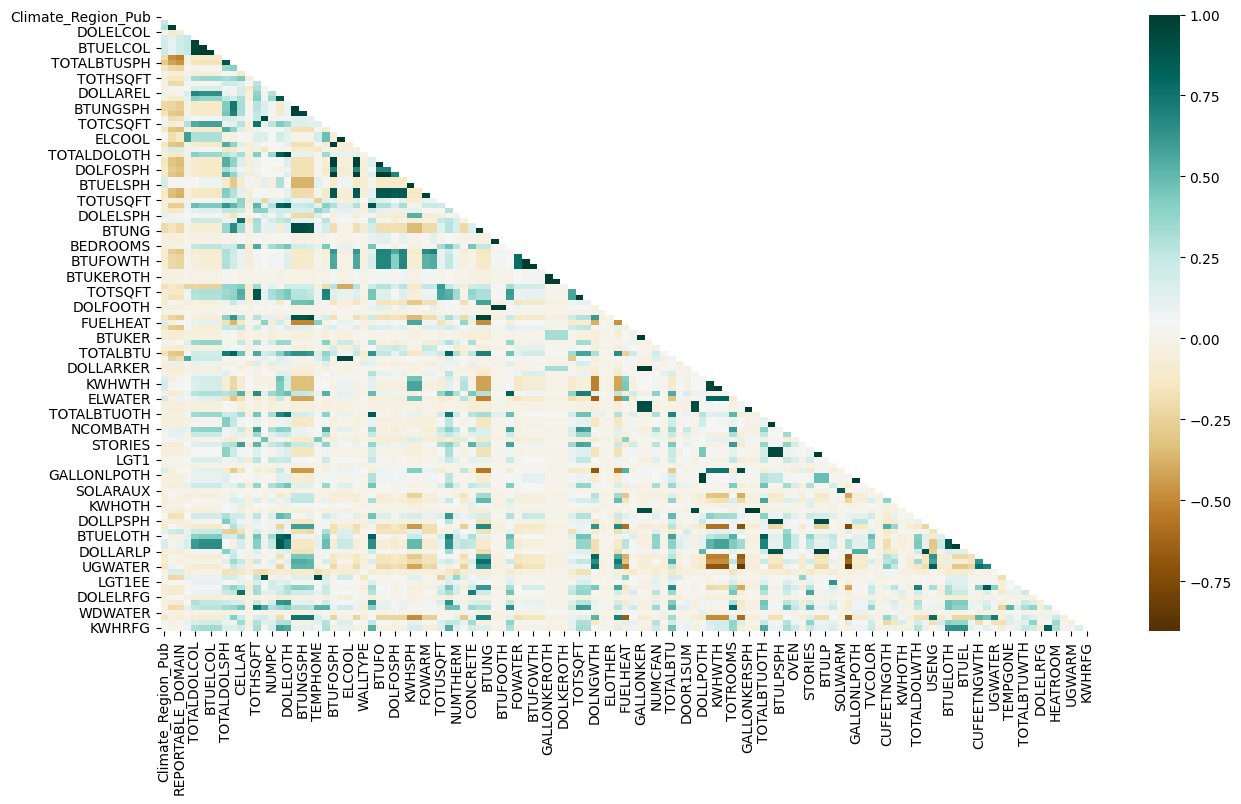

In [153]:
# матрица корреляции

mask = np.triu(np.ones_like(df_enc.corr()))

plt.figure(figsize=(15,8))
sns.heatmap(df_enc.corr(),annot=False, fmt='.2f',  cmap='BrBG', mask=mask)

Визуально видно, что существует достаточно сильная корреляция между некоторыми признаками.

Найдем N наиболее сильно скоррелированных с целевой переменной признаков.

In [154]:
# корреляция между всеми признаками

df_corr = df_enc.corr()

In [155]:
# нахождение и сортировка признаков
# по степени корреляции для TOTALBTU

N = 20

TOTALBTU_corr = df_corr['TOTALBTU']

max_corrs = TOTALBTU_corr.sort_values(key=lambda x: abs(x), ascending = False)[:N]
print(max_corrs)

TOTALBTU       1.000000
TOTALBTUSPH    0.816920
TOTALDOL       0.800261
TOTALDOLSPH    0.720985
CUFEETNG       0.695434
BTUNG          0.695433
TOTALBTUOTH    0.686444
TOTALBTUWTH    0.662131
DOLLARNG       0.657490
CUFEETNGSPH    0.636098
BTUNGSPH       0.636097
TOTALDOLOTH    0.621356
DOLNGSPH       0.599790
BTUELOTH       0.581334
TOTSQFT_EN     0.575831
TOTSQFT        0.571108
DOLELOTH       0.566809
TOTHSQFT       0.556556
TOTROOMS       0.547737
BTUNGWTH       0.532693
Name: TOTALBTU, dtype: float64


#Отбор признаков

Произведем отбор признаков для обучения с помощью библиотеки feature_selector.

Ненужные признаки снижают скорость обучения модели, интерпретируемость и, главное, способность к обобщению. FeatureSelector – это специальный класс для отбора информативных признаков, написанный на языке Python, реализующий самые распространенные методы выборки. Его исходный код доступен на GitHub. Инструмент позволяет оценивать параметры по следующим характеристикам:

* высокий процент пропущенных значений;
* коллинеарность (сильная корреляция);
* нулевая важность в моделях, основанных на деревьях;
* низкая важность;
* единственное значение.


In [156]:
# скопируем датасет в новый фрейм

features = df_enc.copy()

In [157]:
# путь к библиотеке

path_m = path

In [158]:
# добавляем путь

import sys

sys.path.insert(0, path_m)

In [159]:
# импортируем FeatureSelector

from feature_selector import FeatureSelector

In [160]:
# данные и метки

train = df_enc.copy()
train_labels = train['TOTALBTU']

In [161]:
# удаляем целевую переменную

train = train.drop(columns = ['TOTALBTU'])

In [162]:
# создаем объект класса FeatureSelector
# на вход передаем данные и метки

fs = FeatureSelector(data = train, labels = train_labels)

## Коллинеарные признаки

Этот метод находит пары коллинеарных признаков на основе коэффициента корреляции Пирсона. Для каждой пары, превышающей указанный порог (в пересчете на абсолютное значение), он идентифицирует одну из переменных, подлежащих удалению.

Для каждой пары признак, который будет удален, является последним с точки зрения упорядочения столбцов во фрейме данных.

In [163]:
# correlation_threshold - пороговое значение корреляции

fs.identify_collinear(correlation_threshold=0.975)

27 features with a correlation magnitude greater than 0.97.



/content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/feature_selector.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_index = True)
/content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/feature_selector.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_index = True)
/content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/feature_selector.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_index = True)
/content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение

Выведем признаки, порог корреляции которых выше указанного порога, отобранные для удаления.

In [164]:
#список признаков для удаления

collinear_features = fs.ops['collinear']
collinear_features

['REPORTABLE_DOMAIN',
 'BTUELCOL',
 'TOTALBTUCOL',
 'BTUNGSPH',
 'ELCOOL',
 'GALLONFOSPH',
 'BTUFO',
 'GALLONFO',
 'DOLLARFO',
 'BTUELSPH',
 'BTUNG',
 'BTUFOOTH',
 'BTUFOWTH',
 'DOLFOWTH',
 'BTUKEROTH',
 'DOLKEROTH',
 'TOTSQFT_EN',
 'DOLFOOTH',
 'BTUKER',
 'DOLLARKER',
 'BTUELWTH',
 'BTUKERSPH',
 'BTULPSPH',
 'BTULP',
 'BTULPOTH',
 'DOLKERSPH',
 'BTUEL']

Выведем количество обнаруженных признаков.

In [165]:
print("The number of collinear features: ", len(collinear_features))

The number of collinear features:  27


Построим матрицу корреляции для отобранных признаков.

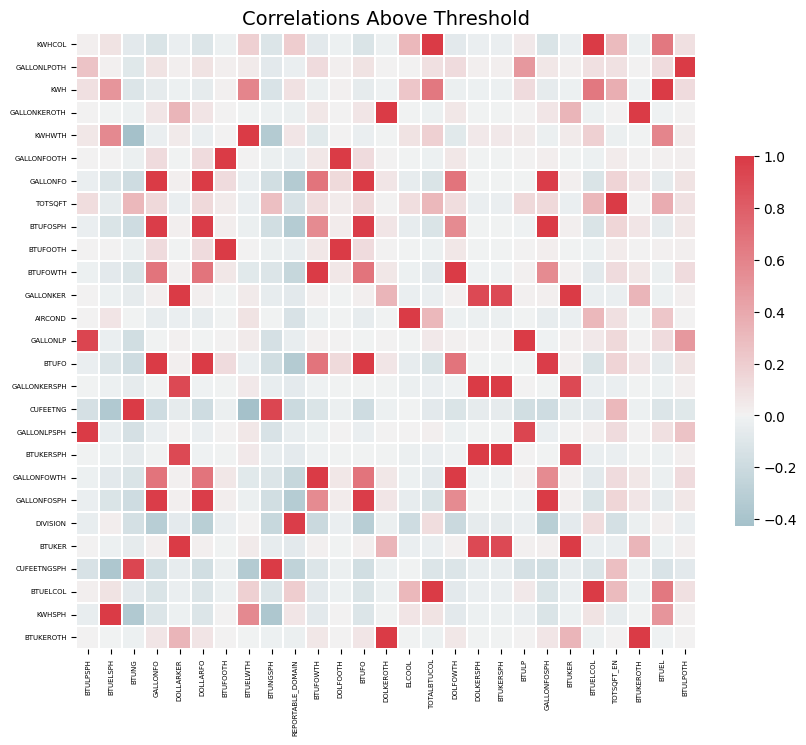

In [166]:
fs.plot_collinear()

И матрицу корреляции для всех признаков.

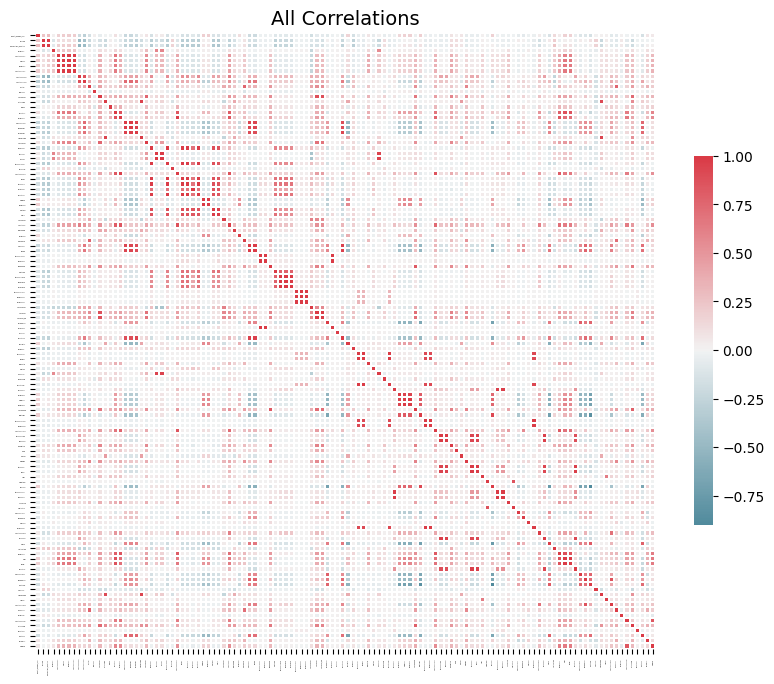

In [167]:
fs.plot_collinear(plot_all=True)

Выведем значение корреляции для признаков. Как видно, встречаются признаки со значением корреляции, равном единице.

In [168]:
fs.record_collinear.head()

,drop_feature,corr_feature,corr_value
0,REPORTABLE_DOMAIN,DIVISION,0.979677
1,BTUELCOL,KWHCOL,1.000000
2,TOTALBTUCOL,KWHCOL,1.000000
3,TOTALBTUCOL,BTUELCOL,1.000000
4,BTUNGSPH,CUFEETNGSPH,1.000000


##Признаки нулевой важности

Этот метод основан на модели машинного обучения для определения признаков, которые необходимо удалить. Следовательно, требуется контролируемая задача обучения с метками. Метод работает путем определения важности объектов с помощью машины повышения градиента, реализованной в библиотеке LightGBM.

Чтобы уменьшить дисперсию в вычисляемых значениях признаков, модель обучается по умолчанию 10 раз. Модель также по умолчанию обучается с ранней остановкой с использованием набора проверок (15% обучающих данных), чтобы определить оптимальное количество оценщиков для обучения.

Методу identify_zero_importance могут быть переданы следующие параметры:

* task: либо классификация, либо регрессия. Метрика и метки должны соответствовать задаче
* eval_metric: показатель, используемый для ранней остановки (например, auc для классификации или l2 для регрессии). Чтобы просмотреть список доступных показателей, обратитесь к документации LightGBM
* n_iterations: количество тренировочных запусков. Значения функций усредняются по результатам обучения (по умолчанию = 10).
* _early_stopping: следует ли использовать раннюю остановку при обучении модели (по умолчанию = True). Ранняя остановка останавливает обучение оценщиков (деревьев решений), когда производительность набора проверок больше не снижается для указанного числа оценок (по умолчанию в этой реализации 100). Ранняя остановка - это форма регуляризации, используемая для предотвращения переобучения обучающим данным


Предостережение: в отличие от других методов, значения признаков из модели недетерминированы (имеют небольшую случайность). Результаты выполнения этого метода могут меняться при каждом его запуске.

In [169]:
# отбор признаков

fs.identify_zero_importance(task = 'regression', eval_metric = 'l2',
                            n_iterations = 10, _early_stopping = True)

Training Gradient Boosting Model

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15454
[LightGBM] [Info] Number of data points in the train set: 8700, number of used features: 113
[LightGBM] [Info] Start training from score 90383.077471
Training until validation scores don't improve for 30 rounds
[100]	valid_0's l2: 3.22248e+07
Early stopping, best iteration is:
[116]	valid_0's l2: 3.1752e+07
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15465
[LightGBM] [Info] Number of data points in the train set: 8700, number of used features: 113
[LightGBM] [Info] Start training from score 89964.390345
Training until validation scores don't improve fo

Выведем признаки с нулевой важностью.

In [170]:
zero_importance_features = fs.ops['zero_importance']
zero_importance_features

['GALLONFOOTH',
 'ELOTHER',
 'UGWARM',
 'WDWATER',
 'BTUELWTH',
 'DOLFOOTH',
 'HEATHOME',
 'ELWATER',
 'UGWATER',
 'AIRCOND',
 'DOLKEROTH',
 'BTUFOOTH',
 'ELCOOL',
 'BTUKEROTH',
 'SOLWARM',
 'FOWARM',
 'USENG',
 'USEFO',
 'SOLARAUX']

И количество zero importance признаков.

In [171]:
print('The number of zero_importance_features: ',len(zero_importance_features))

The number of zero_importance_features:  19


Выведем график важности признаков.

plot_feature_importances выводит график n наиболее важных объектов. Этот график показывает совокупную важность признаков.

При построениее графика можно ввести пороговое значение, которое определяет количество признаков, необходимое для достижения заданной совокупной важности признак. Например, значение threshold = 0.99 сообщит нам количество признаков, необходимых для учета 99% общей важности.

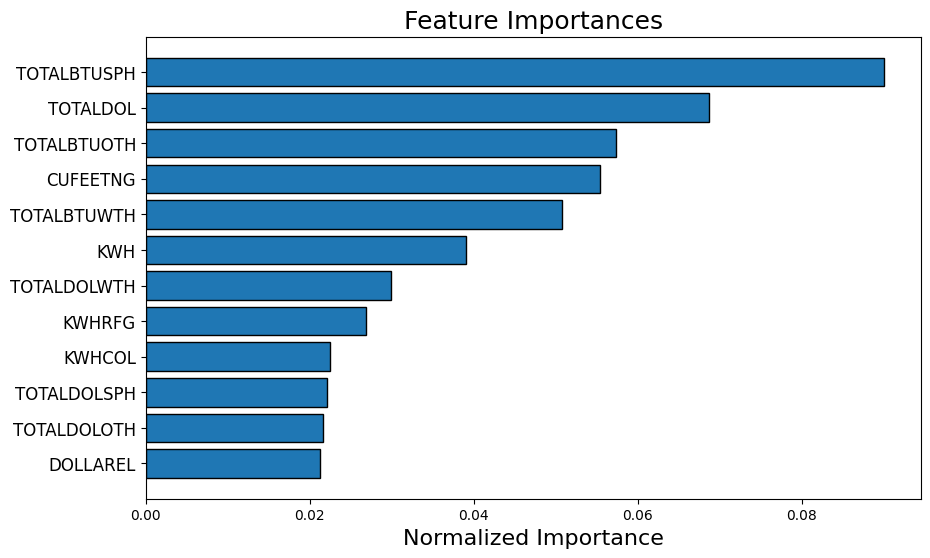

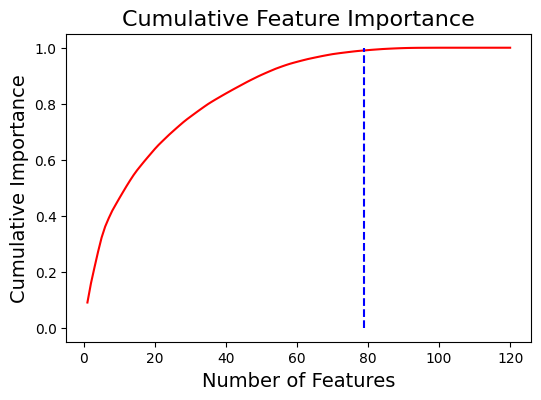

79 features required for 0.99 of cumulative importance


In [172]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

In [173]:
#fs.identify_low_importance(cumulative_importance = 0.99)

## Удаление признаков

Удалим обнаруженные ранее признаки с высокой корреляцией и нулевой важностью.

In [174]:
train_removed = fs.remove(methods = ['collinear', 'zero_importance'], keep_one_hot=False)

Removed 40 features including one-hot features.


Выведем оставшиеся признаки и их количество.

In [175]:
list(train_removed.columns)

['Climate_Region_Pub',
 'DIVISION',
 'DOLELCOL',
 'TOTALDOLCOL',
 'KWHCOL',
 'TOTALDOLSPH',
 'TOTALBTUSPH',
 'CELLAR',
 'NWEIGHT',
 'TOTHSQFT',
 'NUMPC',
 'DOLLAREL',
 'DOLELOTH',
 'CUFEETNGSPH',
 'DOLNGSPH',
 'TEMPHOME',
 'TOTCSQFT',
 'BTUFOSPH',
 'WALLTYPE',
 'TOTALDOLOTH',
 'DOLFOSPH',
 'KWHSPH',
 'TOTUSQFT',
 'TOTALDOL',
 'NUMTHERM',
 'DOLELSPH',
 'CONCRETE',
 'CUFEETNG',
 'BEDROOMS',
 'FOWATER',
 'GALLONFOWTH',
 'GALLONKEROTH',
 'TOTUCSQFT',
 'TOTSQFT',
 'DOLNGWTH',
 'DOLLARNG',
 'FUELHEAT',
 'NOTMOIST',
 'GALLONKER',
 'NUMCFAN',
 'FOILAUX',
 'COOLTYPE',
 'DOOR1SUM',
 'DOLLPOTH',
 'DOLELWTH',
 'KWHWTH',
 'TOTROOMS',
 'GALLONKERSPH',
 'TOTALBTUOTH',
 'GALLONLPSPH',
 'NCOMBATH',
 'OVEN',
 'EQUIPM',
 'STORIES',
 'GALLONLP',
 'LGT1',
 'FUELH2O',
 'GALLONLPOTH',
 'TVCOLOR',
 'CUFEETNGOTH',
 'BTUNGOTH',
 'KWHOTH',
 'TOTALDOLWTH',
 'DOLLPSPH',
 'YEARMADE',
 'BTUELOTH',
 'KWH',
 'DOLLARLP',
 'CUFEETNGWTH',
 'BTUNGWTH',
 'SDESCENT',
 'TEMPGONE',
 'LGT1EE',
 'TOTALBTUWTH',
 'ROOFTYPE',
 'DO

In [176]:
print('The number of selected features: ', len(train_removed.columns))

The number of selected features:  80


Посмотрим пересечение оставшихся признаков с N наиболее скоррелированными с целевой переменной.

In [177]:
list1 = list(train_removed.columns)
list2 = list(max_corrs.index)

intersection = list(set(list1) & set(list2))

print(intersection)
print('The number of features in intersecrion: ', len(intersection))

['TOTSQFT', 'TOTALBTUOTH', 'DOLELOTH', 'DOLNGSPH', 'BTUNGWTH', 'CUFEETNGSPH', 'TOTALDOL', 'TOTALBTUWTH', 'TOTALDOLSPH', 'TOTHSQFT', 'DOLLARNG', 'TOTROOMS', 'TOTALDOLOTH', 'TOTALBTUSPH', 'CUFEETNG', 'BTUELOTH']
The number of features in intersecrion:  16


Как видим, большая часть наиболее скоррелированных признаков вошла в отобранные.

##Признаки с константными значениями

Найдем в отобранных признаках также признаки с константными значениями и признаки с малым отклонением.

In [178]:
# зададим порог
threshold = 0.85

columns_with_constant_values = []

for c in train_removed.columns:

  value_frequencies = train_removed[c].value_counts(normalize=True)
  #print(value_frequencies)
  if value_frequencies.max() >= 0.85:
    columns_with_constant_values.append(c)

print(columns_with_constant_values)
print(len(columns_with_constant_values))

['BTUFOSPH', 'DOLFOSPH', 'FOWATER', 'GALLONFOWTH', 'GALLONKEROTH', 'NOTMOIST', 'GALLONKER', 'FOILAUX', 'DOLLPOTH', 'GALLONKERSPH', 'GALLONLPSPH', 'OVEN', 'GALLONLP', 'GALLONLPOTH', 'DOLLPSPH', 'DOLLARLP', 'SDESCENT']
17


Удалим найденные признаки.

In [179]:
without_const_v_df = train_removed.copy()

for col in columns_with_constant_values:
    if col in without_const_v_df.columns:
        del without_const_v_df[col]
        #print(col)


И выведем итоговое количество признаков для обучения.

In [180]:
print('The number of features: ', len(without_const_v_df.columns))

The number of features:  63


#Разделение данных на выборки

In [181]:
# отобранные признаки

#selected_X = train_removed.copy()

selected_X = without_const_v_df.copy()

In [182]:
# целевая переменная

y = df_enc['TOTALBTU']

In [183]:
# выполянем стандартизацию признаков

st_scaler = StandardScaler()
selected_X = st_scaler.fit_transform(selected_X)

In [184]:
# выборки для обучения

X_train, X_test, y_train, y_test = train_test_split(
  selected_X,
  y,
  train_size=0.7,
  random_state=0
)

In [185]:
# выборки для тестирования и валидации

X_test, X_val, y_test, y_val = train_test_split(
  X_test,
  y_test,
  train_size=0.5,
  random_state=0
)

#Наборы нейросетевых архитектур

##Модель №1

Создадим сначала очень простую модель с двумя полносвязными слоями, в первом из которых 32 нейрона, а во втором - выходном - 1. Функция активации первого слоя relu, второго - linear.

In [186]:
model_1 = Sequential()

model_1.add(Dense(32, activation='relu'))
model_1.add(Dense(1, activation='linear'))

###Настройка параметров обучения

В качестве оптимизатора выберем adam.

In [187]:
model_1.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
  )

###Обучение модели

Произведем обучение модели на 50 эпохах.

In [188]:
history_1 = model_1.fit(
    X_train,
    y_train,
    batch_size=10,
    validation_data=(X_val,y_val),
    epochs = 50
  )

Epoch 1/50
762/762 [==============================] - 4s 4ms/step - loss: 11218120704.0000 - mae: 90505.7422 - mse: 11218122752.0000 - val_loss: 11159390208.0000 - val_mae: 89875.8594 - val_mse: 11159390208.0000
Epoch 2/50
762/762 [==============================] - 3s 3ms/step - loss: 11142128640.0000 - mae: 90236.6797 - mse: 11142128640.0000 - val_loss: 11040612352.0000 - val_mae: 89454.7031 - val_mse: 11040612352.0000
Epoch 3/50
762/762 [==============================] - 2s 3ms/step - loss: 10980511744.0000 - mae: 89653.0391 - mse: 10980511744.0000 - val_loss: 10841818112.0000 - val_mae: 88738.7344 - val_mse: 10841818112.0000
Epoch 4/50
762/762 [==============================] - 2s 2ms/step - loss: 10742529024.0000 - mae: 88794.0469 - mse: 10742529024.0000 - val_loss: 10575393792.0000 - val_mae: 87773.4609 - val_mse: 10575393792.0000
Epoch 5/50
762/762 [==============================] - 2s 2ms/step - loss: 10440331264.0000 - mae: 87709.0078 - mse: 10440331264.0000 - val_loss: 1024391

###Оценка модели

Оценим модель. Выведем метрики.

In [189]:
print_metrics(model_1, X_test, y_test)

51/51 [==============================] - 0s 2ms/step
Mean squared error from neural network:  794812681.8348074
Mean absolute error from neural network:  21566.940508498068
R2 score from neural network:  0.7064844574887623


Визуализируем процесс обучения.

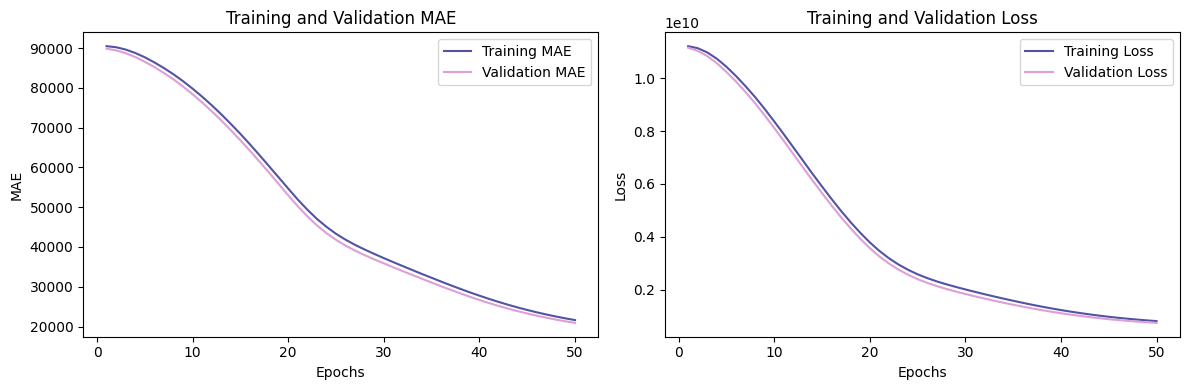

In [190]:
mae_and_loss_visualization(history_1, colors)

И выведем тестовые значения и их оценку.

51/51 [==============================] - 0s 1ms/step


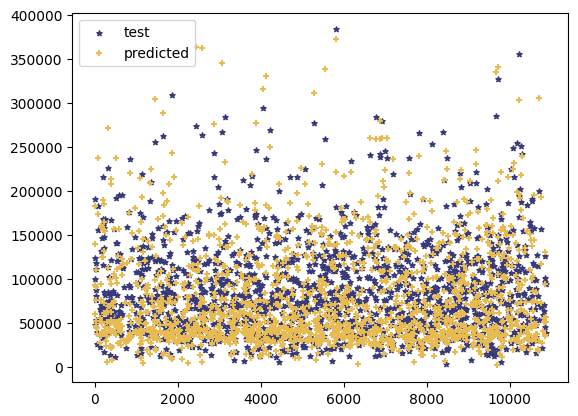

In [191]:
prediction_visialization(model_1, X_test, y_test, colors)

С учетом вычисленных метрик модель можно считать приемлемой.

##Модель №2

Увеличим число нейронов в слоях и добавим ещё один слой с функцией активации relu.

In [192]:
model_2 = Sequential()

model_2.add(Dense(256, activation='relu'))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(1, activation='linear'))

###Настройка параметров обучения

Параметры обучения оставим такими же, как и у предыдущей модели.

In [193]:
model_2.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
  )

###Обучение модели

Обучим модель на 50 эпохах.

In [194]:
history_2 = model_2.fit(
    X_train,
    y_train,
    batch_size=10,
    validation_data=(X_val,y_val),
    epochs = 50
  )

Epoch 1/50
762/762 [==============================] - 3s 3ms/step - loss: 6642171392.0000 - mae: 66718.8281 - mse: 6642171392.0000 - val_loss: 1787684608.0000 - val_mae: 35432.2578 - val_mse: 1787684608.0000
Epoch 2/50
762/762 [==============================] - 3s 4ms/step - loss: 1127069056.0000 - mae: 26128.0352 - mse: 1127069056.0000 - val_loss: 653863872.0000 - val_mae: 19555.1816 - val_mse: 653863872.0000
Epoch 3/50
762/762 [==============================] - 3s 4ms/step - loss: 581219392.0000 - mae: 18184.1582 - mse: 581219392.0000 - val_loss: 464228000.0000 - val_mae: 16228.8418 - val_mse: 464228000.0000
Epoch 4/50
762/762 [==============================] - 2s 3ms/step - loss: 410059360.0000 - mae: 15291.3740 - mse: 410059360.0000 - val_loss: 332244704.0000 - val_mae: 13719.0918 - val_mse: 332244704.0000
Epoch 5/50
762/762 [==============================] - 2s 3ms/step - loss: 291370272.0000 - mae: 12830.4121 - mse: 291370304.0000 - val_loss: 238441264.0000 - val_mae: 11434.6328 

###Оценка модели

Выведем метрики.

In [195]:
print_metrics(model_2, X_test, y_test)

51/51 [==============================] - 0s 2ms/step
Mean squared error from neural network:  105805.61751830907
Mean absolute error from neural network:  210.25018231960837
R2 score from neural network:  0.9999609271543644


Визуализируем процесс обучения.

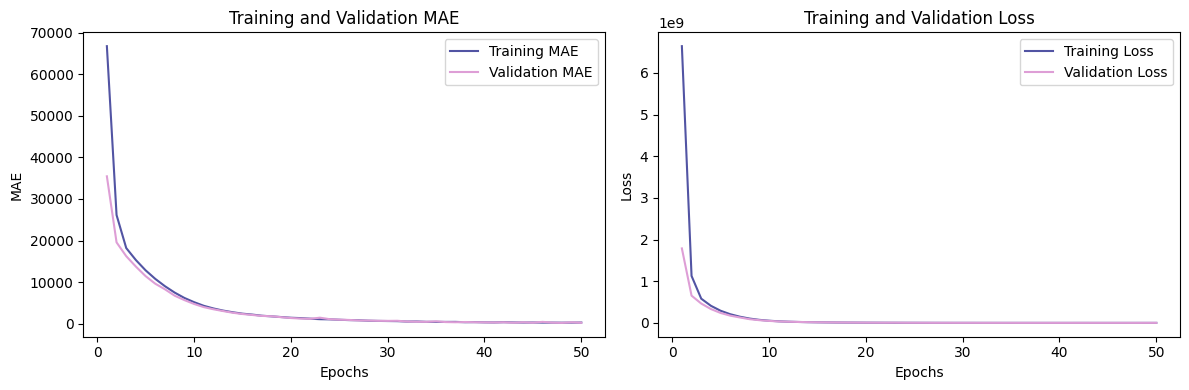

In [196]:
mae_and_loss_visualization(history_2, colors)

Построим на графике тестовые и предсказанные значения.

51/51 [==============================] - 0s 2ms/step


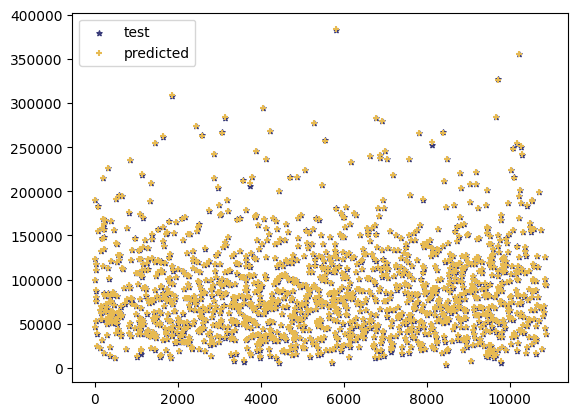

In [197]:
prediction_visialization(model_2, X_test, y_test, colors)

Значения на графике практически совпадают, а коэффициент детерминации очень близок к единице.

##Модель №3

Попробуем изменить параметры оптимизации предыдущей модели.

In [198]:
model_3 = Sequential()

model_3.add(Dense(256, activation='relu'))
model_3.add(Dense(128, activation='relu'))
model_3.add(Dense(1, activation='linear'))

###Настройка параметров обучения

Выберем оптимизатор RMSprop как более простой по сравнению с adam алготм оптимизации.

In [199]:
model_3.compile(
    loss='mean_squared_error',
    optimizer='RMSprop',
    metrics=['mae', 'mse']
  )

###Обучение модели

Обучим модель.

In [200]:
history_3 = model_3.fit(
    X_train,
    y_train,
    batch_size=10,
    validation_data=(X_val,y_val),
    epochs = 50
  )

Epoch 1/50
762/762 [==============================] - 3s 3ms/step - loss: 8502940672.0000 - mae: 78632.8047 - mse: 8502940672.0000 - val_loss: 2927607040.0000 - val_mae: 47221.4492 - val_mse: 2927607040.0000
Epoch 2/50
762/762 [==============================] - 2s 3ms/step - loss: 1730924288.0000 - mae: 33566.4258 - mse: 1730924288.0000 - val_loss: 816406592.0000 - val_mae: 22479.3066 - val_mse: 816406592.0000
Epoch 3/50
762/762 [==============================] - 2s 3ms/step - loss: 661480832.0000 - mae: 19336.4629 - mse: 661480832.0000 - val_loss: 485783712.0000 - val_mae: 16634.0781 - val_mse: 485783712.0000
Epoch 4/50
762/762 [==============================] - 3s 4ms/step - loss: 422725312.0000 - mae: 15366.7285 - mse: 422725312.0000 - val_loss: 324055136.0000 - val_mae: 13442.7148 - val_mse: 324055136.0000
Epoch 5/50
762/762 [==============================] - 3s 5ms/step - loss: 279330080.0000 - mae: 12460.8916 - mse: 279330080.0000 - val_loss: 220270640.0000 - val_mae: 10900.2979 

###Оценка модели

Выведем метрики.

In [201]:
print_metrics(model_3, X_test, y_test)

51/51 [==============================] - 0s 2ms/step
Mean squared error from neural network:  271542.34529729025
Mean absolute error from neural network:  410.4838525899563
R2 score from neural network:  0.9998997224118131


Построим визуализацию процесса обучения.

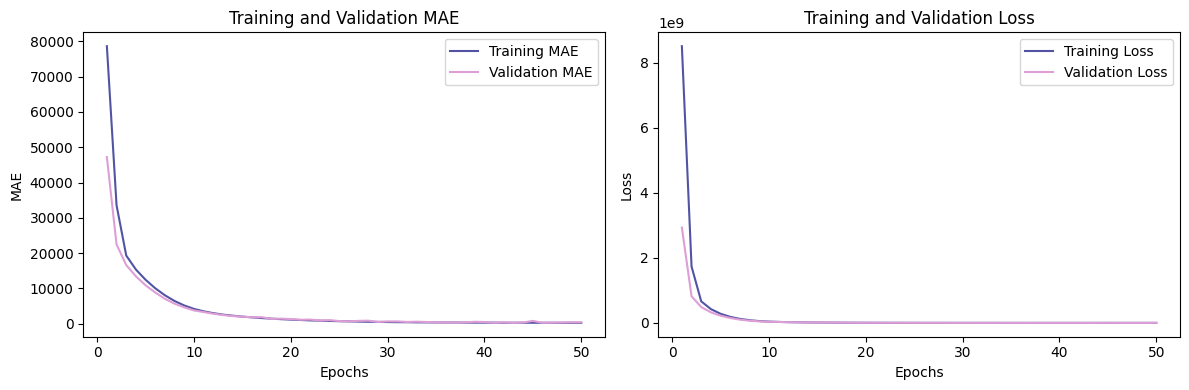

In [202]:
mae_and_loss_visualization(history_3, colors)

Выведем тестовые и предсказанные значения целевой переменной.

51/51 [==============================] - 0s 2ms/step


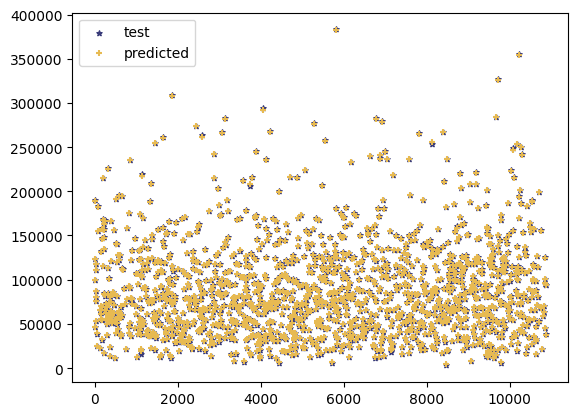

In [203]:
prediction_visialization(model_3, X_test, y_test, colors)

Результат использования оптимизатора RMSprop практически неотличим от adam.

##Модель №4

Изменим функции активации во внутренних слоях на selu и увеличим количество слоёв и нейронов. Построим нейронную сеть с четырьмя слоями с количеством нейронов 512б 256б 128 и 1 от входного к выходному слою соответственно.

In [204]:
model_4 = Sequential()

model_4.add(Dense(512, activation='selu'))
model_4.add(Dense(256, activation='selu'))
model_4.add(Dense(128, activation='selu'))
model_4.add(Dense(1, activation='linear'))

###Настройка параметров обучения

Выберем оптимизатор adam как наиболее оптимальный.

In [205]:
model_4.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
  )

###Обучение модели

Обучим модель на 50 эпохах.

In [206]:
history_4 = model_4.fit(
    X_train,
    y_train,
    batch_size=10,
    validation_data=(X_val,y_val),
    epochs = 50
  )

Epoch 1/50
762/762 [==============================] - 6s 7ms/step - loss: 2854915584.0000 - mae: 39509.7344 - mse: 2854915584.0000 - val_loss: 821577920.0000 - val_mae: 20468.8750 - val_mse: 821577920.0000
Epoch 2/50
762/762 [==============================] - 7s 9ms/step - loss: 361640160.0000 - mae: 11503.9346 - mse: 361640160.0000 - val_loss: 35438044.0000 - val_mae: 3976.2649 - val_mse: 35438044.0000
Epoch 3/50
762/762 [==============================] - 4s 5ms/step - loss: 27422432.0000 - mae: 3234.8882 - mse: 27422432.0000 - val_loss: 15216060.0000 - val_mae: 2456.3132 - val_mse: 15216060.0000
Epoch 4/50
762/762 [==============================] - 4s 6ms/step - loss: 14092928.0000 - mae: 2312.9031 - mse: 14092928.0000 - val_loss: 10672535.0000 - val_mae: 2265.1533 - val_mse: 10672535.0000
Epoch 5/50
762/762 [==============================] - 7s 9ms/step - loss: 8252729.0000 - mae: 1795.6414 - mse: 8252729.5000 - val_loss: 5940160.0000 - val_mae: 1597.0996 - val_mse: 5940160.0000
Epo

###Оценка модели

Выведем метрики.

In [207]:
print_metrics(model_4, X_test, y_test)

51/51 [==============================] - 0s 2ms/step
Mean squared error from neural network:  381535.0292974229
Mean absolute error from neural network:  470.78749362330433
R2 score from neural network:  0.9998591033287834


Построим графики MAE и функции потерь во время процесса обучения.

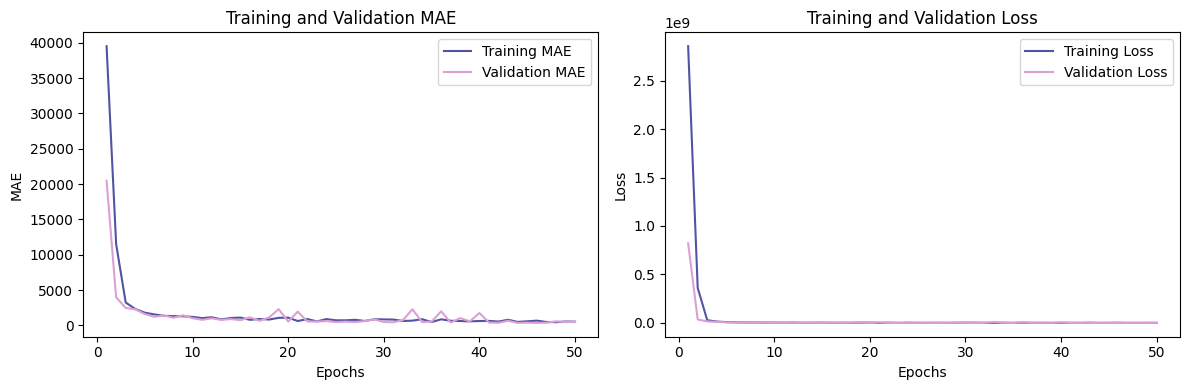

In [208]:
mae_and_loss_visualization(history_4, colors)

Выведем тестовые и предсказанные значения.

51/51 [==============================] - 0s 3ms/step


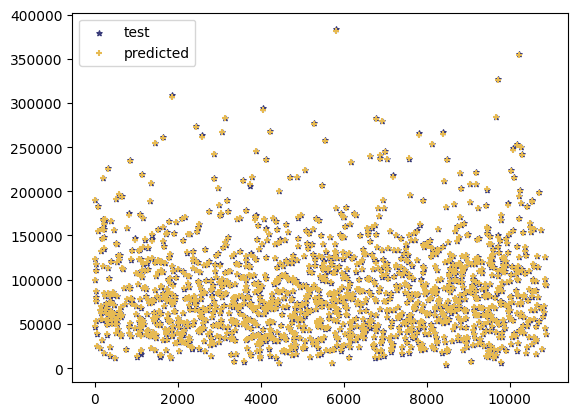

In [209]:
prediction_visialization(model_4, X_test, y_test, colors)

# Выводы

Наилучший результат продемонстрировала модель №2 с тремя полносвязными слоями (256, 128 и 1 нейронов, фукнция активации выходного слоя линейная, остальных - relu), при этом изменение выбранного оптимизатора (adam и RMSprop) на процессе обучения сказалось незначительно. Модель с меньшим количеством слоев и нейронов является недообученной, добавление слоев и нейронов также не улучшает результат.